# Observing Run Preparation Module

**Lecturer:** Robert Quimby<br>
**Jupyter Notebook Author:** Shubham Srivastav, Cameron Hummels & Robert Quimby

This is a Jupyter notebook lesson taken from the GROWTH Summer School 2019.  For other lessons and their accompanying lectures, please see: http://growth.caltech.edu/growth-astro-school-2018-resources.html

## Objective
Demonstrate how to plan observations prior to an observing run.

## Key steps
- Select targets
- Get visibility and airmass plots
- Get moon separation angles
- Calculate exposure times for targets

## Required dependencies

See GROWTH school webpage for detailed instructions on how to install these modules and packages.  Nominally, you should be able to install the python modules with `pip install <module>`.  The external astromatic packages are easiest installed using package managers (e.g., `rpm`, `apt-get`).

### Python modules
* python 3
* astropy
* numpy
* matplotlib
* astroplan
* pytz

### External packages
None

In [1]:
import numpy as np
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.coordinates import EarthLocation
import pytz
%matplotlib inline
from astroplan import Observer, FixedTarget
from astropy.utils.iers import conf
conf.auto_max_age = None
from astroplan import download_IERS_A 
from astropy.coordinates import get_sun, get_moon, get_body
from astroplan import moon_illumination

### Date and Time
- Dates and times are in UTC
- Default time is 00:00:00 UTC (verify this)

In [2]:
date = Time("2018-12-03", format='iso')
print(date)

2018-12-03 00:00:00.000


### What is the current UTC?

In [3]:
now = Time.now()
print(now)
print(now.jd)
print(now.mjd)
print(now.decimalyear)

2020-02-20 20:40:51.647695
2458900.3617088855
58899.86170888536
2020.1389664177195


### Exercise
What time will it be (in UTC) after 1 hour 45 minutes from `now`? Complete the line below to print it out.

In [4]:
print('now:               ',now)
print('1h 45mins from now:',now + 1*u.h + 45*u.min)

now:                2020-02-20 20:40:51.647695
1h 45mins from now: 2020-02-20 22:25:51.647695


### Using UT1
- To keep accurate time, the changes in earth's rotation period have to be taken into account.
- AstroPy does this using a convention called UT1, that is tied to the rotation of earth with respect to the position of distant quasars. IERS - International Earth Rotation and Reference Systems Service keeps continuous tabs on the orientation of the earth and updates the data in the IERS bulletin.
Update the bulletin:

In [5]:
download_IERS_A()

### Check to see what observatories are available in the database.

In [6]:
print("Available observatories: \n{0}"
      .format(', '.join(EarthLocation.get_site_names())))

Available observatories: 
, , , ALMA, ATST, Anglo-Australian Observatory, Apache Point, Apache Point Observatory, Atacama Large Millimeter Array, BAO, BBSO, Beijing XingLong Observatory, Black Moshannon Observatory, CHARA, Canada-France-Hawaii Telescope, Catalina Observatory, Cerro Pachon, Cerro Paranal, Cerro Tololo, Cerro Tololo Interamerican Observatory, DCT, DKIST, Discovery Channel Telescope, Dominion Astrophysical Observatory, GBT, Gemini South, Green Bank Telescope, Hale Telescope, Haleakala Observatories, Happy Jack, IAO, JCMT, James Clerk Maxwell Telescope, Jansky Very Large Array, Keck Observatory, Kitt Peak, Kitt Peak National Observatory, La Silla Observatory, Large Binocular Telescope, Las Campanas Observatory, Lick Observatory, Lowell Observatory, MWA, Manastash Ridge Observatory, McDonald Observatory, Medicina, Medicina Dish, Michigan-Dartmouth-MIT Observatory, Mount Graham International Observatory, Mt Graham, Mt. Ekar 182 cm. Telescope, Mt. Stromlo Observatory, Multipl

### Setting up observatory location

In [7]:
# # Mount Laguna Observatory is not listed in the database; let's define the location
latitude = 32.842167 * u.deg
longitude = -116.426938 * u.deg
elevation = 1860 * u.m
location = EarthLocation.from_geodetic(longitude, latitude, elevation)
mlo = Observer(location = location, timezone = 'America/Los_Angeles',
                             name = "MLO", description = "MLO 1.0-m telescope")
mlo

In [8]:
KittPeak = Observer.at_site("Kitt Peak", timezone="US/Hawaii")
KittPeak

<Observer: name='Kitt Peak',
    location (lon, lat, el)=(-111.6 deg, 31.963333333333342 deg, 2119.999999997953 m),
    timezone=<DstTzInfo 'US/Hawaii' LMT-1 day, 13:29:00 STD>>

### Sunset, Sunrise, Midnight

In [9]:
# ##### just for testing...REMOVE! #####
# now = Time('2020-02-20 21:17:59')

In [10]:
# Calculating the sunset, midnight and sunrise times for our observatory 
# What is astronomical twilight?
sunset_KittPeak = KittPeak.sun_set_time(now, which='nearest')
eve_twil_KittPeak = KittPeak.twilight_evening_astronomical(now, which='nearest')
midnight_KittPeak = KittPeak.midnight(now, which='next')
morn_twil_KittPeak = KittPeak.twilight_morning_astronomical(now, which='next')
sunrise_KittPeak = KittPeak.sun_rise_time(now, which='next')

print("Sunset at Kitt Peak will be at \n{0.iso} UTC".format(sunset_KittPeak))
print("Astronomical evening twilight at Kitt Peak will be at \n{0.iso} UTC".format(eve_twil_KittPeak))
print("Midnight at Kitt Peak will be at \n{0.iso} UTC".format(midnight_KittPeak))
print("Astronomical morning twilight at Kitt Peak will be at \n{0.iso} UTC".format(morn_twil_KittPeak))
print("Sunrise at Kitt Peak will be at \n{0.iso} UTC".format(sunrise_KittPeak))

Sunset at Kitt Peak will be at 
2020-02-21 01:12:43.210 UTC
Astronomical evening twilight at Kitt Peak will be at 
2020-02-21 02:38:26.802 UTC
Midnight at Kitt Peak will be at 
2020-02-21 07:39:58.571 UTC
Astronomical morning twilight at Kitt Peak will be at 
2020-02-21 12:41:21.314 UTC
Sunrise at Kitt Peak will be at 
2020-02-21 14:06:56.250 UTC


### Exercise 
Find the effective length of time (in hours) available for optical astronomical observations at MLO tonight

In [11]:
eve_twil_KittPeak = KittPeak.twilight_evening_astronomical(now, which='nearest')
morn_twil_KittPeak = KittPeak.twilight_morning_astronomical(now, which='next')
(morn_twil_KittPeak - eve_twil_KittPeak).to(u.hour)

<Quantity 10.04847549 h>

### Local Sidereal Time (LST)

In [12]:
#What is the LST now at KittPeak?
#What would the LST be at KittPeak at local midnight?
lst_now = KittPeak.local_sidereal_time(now)
lst_mid = KittPeak.local_sidereal_time(midnight_KittPeak)
print("LST at KittPeak now is \n{0:.2f}".format(lst_now))
print("LST at KittPeak at local midnight will be \n{0:.2f}".format(lst_mid))

LST at KittPeak now is 
23.26 hourangle
LST at KittPeak at local midnight will be 
10.27 hourangle


### Choosing targets for observations
Targets can be defined by name or coordinates.


In [54]:
# using coordinates
coords = SkyCoord('18h53m35.097s +33d01m44.8831s', frame='icrs') # coordinates of the Ring Nebula (M57) 
m57 = FixedTarget(name = 'M57', coord=coords)
m57.ra.hms

hms_tuple(h=18.0, m=53.0, s=35.09699999999441)

In [55]:
# by name
target = FixedTarget.from_name('m61') # Messier
target.coord

<SkyCoord (ICRS): (ra, dec) in deg
    (185.47886465, 4.47377454)>

Check to see if target is "up" at evening twilight (assume "up" means more than 30 degrees above the horizon). Also check if target is available at midnight and morning twilight.

In [56]:
# check if the target is up
print(KittPeak.target_is_up(eve_twil_KittPeak, target, horizon=30*u.deg))
print(KittPeak.target_is_up(midnight_KittPeak, target, horizon=30*u.deg))
print(KittPeak.target_is_up(morn_twil_KittPeak, target, horizon=30*u.deg))

False
True
True


In [57]:
# Altitude and Azimuth of target at evening twilight
aa = KittPeak.altaz(eve_twil_KittPeak, target)
aa.alt.degree, aa.az.degree

(-12.141609098516062, 76.9419497835193)

Determine the time at which the target rises

In [58]:
targetrise = KittPeak.target_rise_time(now, target, which = 'next', horizon=0*u.deg)
print(targetrise.iso)  #default format is JD

2020-02-21 03:36:18.100


### Dealing with moving targets

In [59]:
get_body('jupiter', now)

<SkyCoord (GCRS: obstime=2020-02-20 20:40:51.647695, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (288.99127196, -22.28042257, 5.87635517)>

In [60]:
# get moon position at midnight 
get_moon(midnight_KittPeak)

<SkyCoord (GCRS: obstime=2458900.8194279, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, km)
    (308.90817929, -21.19644682, 397704.08054803)>

In [61]:
# How bright is the moon at midnight?
moon_illumination(midnight_KittPeak)

0.05117472363917286

In [62]:
# We can turn solar system objects into 'pseudo-fixed' targets to plan observations
saturn_midnight = FixedTarget(name = 'Saturn', coord = get_body('saturn', midnight_KittPeak))
saturn_midnight.coord

<SkyCoord (GCRS: obstime=2458900.8194279, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (299.057851, -20.76274016, 10.82467695)>

### Airmass
- Ideally, targets should be observed when they have the least airmass. Airmass ranges from 1 (zenith) to ~38 at the horizon.
- Airmass is 2.0 at alt=30, 2.9 at alt=20 and 3.9 at alt=15 degrees
- As a general rule of thumb, try observing targets when airmass < 2
- Let us find the airmass of M57 at midnight at MLO

In [63]:
#Is the target up at MLO at midnight?
KittPeak.target_is_up(midnight_KittPeak, target)

True

In [64]:
#lets check the alt and az of the target at midnight
target_altaz = KittPeak.altaz(midnight_KittPeak, target)
target_altaz.altaz

<SkyCoord (AltAz: obstime=2458900.8194279, location=(-1994502.60430614, -5037538.54232911, 3358104.99690298) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (126.34247524, 49.50222627)>

That is high over head; ideal for observing.

In [65]:
#Find the airmass
target_altaz.secz

<Quantity 1.31504336>

### Plots to help planning

Now we can visualize what we have done so far using some plots

In [66]:
import matplotlib.pyplot as plt
from astroplan.plots import plot_sky, plot_airmass

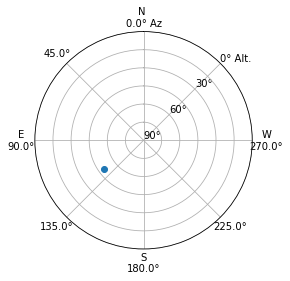

In [67]:
#position of target at midnight
plot_sky(target, KittPeak, midnight_KittPeak);

Now let us see how the target moves over the course of the night

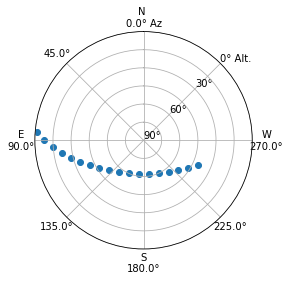

In [68]:
t_start = eve_twil_KittPeak
t_end = morn_twil_KittPeak
t_observe = t_start + (t_end - t_start) * np.linspace(0.0, 1.0, 20)
plot_sky(target, KittPeak, t_observe);

Now let's plot the airmass as a function of time

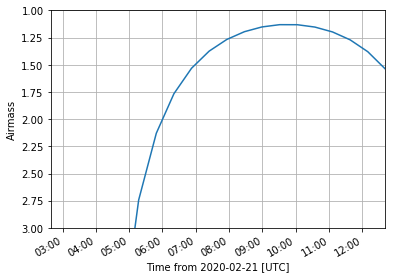

In [28]:
plot_airmass(target, KittPeak, t_observe)
plt.grid();

The airmass is above 2 for the better part of the night, making M57 a good summer target from MLO.
Note that the default airmass limit is 3 in astroplan, corresponding to ~19 degrees elevation.

### Finder Charts

In [69]:
from astroplan.plots import plot_finder_image
from astroquery.skyview import SkyView

Load an image of the field in which the target lies.

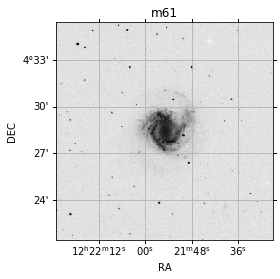

In [70]:
# field of view corresponding to the MLO 1.0-m telesocpe
fov = 14*u.arcmin

# plot the image
plot_finder_image(target, fov_radius=fov);  

Now let's define an array of targets to work with

In [71]:
target_names = ['vega', 'polaris', 'm1', 'm42', 'm55']
targets = [FixedTarget.from_name(target) for target in target_names]
targets

[<FixedTarget "vega" at SkyCoord (ICRS): (ra, dec) in deg (279.23473479, 38.78368896)>,
 <FixedTarget "polaris" at SkyCoord (ICRS): (ra, dec) in deg (37.95456067, 89.26410897)>,
 <FixedTarget "m1" at SkyCoord (ICRS): (ra, dec) in deg (83.63308333, 22.0145)>,
 <FixedTarget "m42" at SkyCoord (ICRS): (ra, dec) in deg (83.82208333, -5.39111111)>,
 <FixedTarget "m55" at SkyCoord (ICRS): (ra, dec) in deg (294.99879167, -30.96475)>]

Which of these targets are up now?

In [72]:
KittPeak.target_is_up(now, targets)

array([ True,  True,  True, False,  True])

Which of these targets are up at local midnight?

In [33]:
KittPeak.target_is_up(midnight_KittPeak, targets)

array([False,  True,  True,  True, False])

### Exercise
Find out the times at which the targets rise to an elevation of 10 degrees. Use target_rise_time. 

In [34]:
for target in targets:
    rise = KittPeak.target_rise_time(now, target, which = 'next', horizon=10*u.deg)
    print(target.name, rise.iso)

vega 2020-02-21 09:05:37.979
polaris --
m1 2020-02-20 20:53:50.686
m42 2020-02-20 22:02:46.734
m55 2020-02-21 13:34:53.412


How high is Vega above the horizion now?

In [35]:
KittPeak.altaz(now, targets[0])

<SkyCoord (AltAz: obstime=2020-02-20 20:40:51.647695, location=(-1994502.60430614, -5037538.54232911, 3358104.99690298) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    (297.92630751, 34.30555767)>

Now let's plot the elevation of Vega to see how it varies over the night

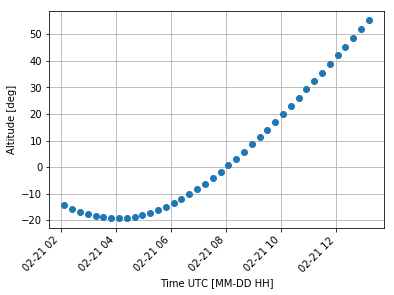

In [36]:
times = (t_start - 0.5 * u.h) + (t_end - t_start + 1 * u.h) * np.linspace(0.0, 1.0, 40)
elevations = KittPeak.altaz(times, targets[0]).alt
ax = plt.gca()
ax.plot_date(times.plot_date, elevations.deg)
ax.set(xlabel = 'Time UTC [MM-DD HH]', ylabel = 'Altitude [deg]')
plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
plt.grid()

### Exercise
Plot the altitude as a function of time for tonight for each of the targets in a single plot

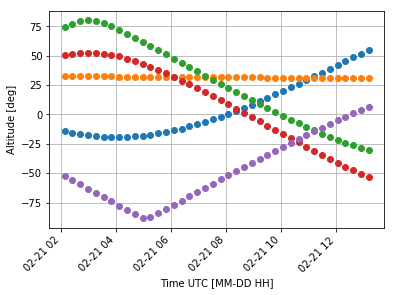

In [37]:
for target in targets:
    elevations = KittPeak.altaz(times, target).alt

    ax = plt.gca()
    ax.plot_date(times.plot_date, elevations.deg)
    ax.set(xlabel = 'Time UTC [MM-DD HH]', ylabel = 'Altitude [deg]')
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    plt.grid()

### Exercise
Plot sky positions for each target using plot_sky for tonight at MLO in a single plot.

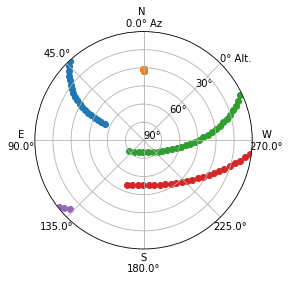

In [38]:
for target in targets:
    plot_sky(target, KittPeak, times);

### Exercise
Plot airmass vs time for each target in targets for tonight at MLO.

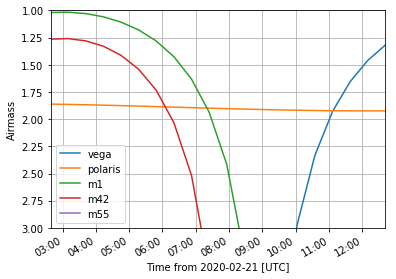

In [39]:
for target in targets:
    plot_airmass(target, KittPeak, t_observe)
    plt.legend()
    plt.grid()

### Observational Constraints
You can set specific constraints that define when a target is "observable"
- twilight level (e.g., "Civil")
- airmass
- altitude limits

In [40]:
from astroplan import (AltitudeConstraint, AirmassConstraint,
                       AtNightConstraint, MoonSeparationConstraint)
constraints = [AltitudeConstraint(15*u.deg, 84*u.deg),
               AirmassConstraint(3), AtNightConstraint.twilight_civil(), MoonSeparationConstraint(min = 10 * u.deg)]
t_range = Time([t_start - 0.5 * u.hour, t_end + 0.5 * u.hour])

In [41]:
from astroplan import is_observable, is_always_observable, months_observable

# Are targets ever observable in the time range?
ever_observable = is_observable(constraints, KittPeak, targets, time_range=t_range)
print(ever_observable)

# Are targets always observable in the time range?
always_observable = is_always_observable(constraints, KittPeak, targets, time_range=t_range)
print(always_observable)

[ True  True  True  True False]
[False  True False False False]


The functions is_observable and ever_observable return boolean arrays. Let's print their output in tabular form.

In [42]:
from astropy.table import Table
observability_table = Table()
observability_table['targets'] = [target.name for target in targets]
observability_table['ever_observable'] = ever_observable
observability_table['always_observable'] = always_observable
print(observability_table)

targets ever_observable always_observable
------- --------------- -----------------
   vega            True             False
polaris            True              True
     m1            True             False
    m42            True             False
    m55           False             False


Or we could do this directly using the observability_table function 

In [43]:
from astroplan import observability_table
table = observability_table(constraints, KittPeak, targets, time_range = t_range)
print(table)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
       vega            True             False         0.30434782608695654
    polaris            True              True                         1.0
         m1            True             False          0.5652173913043478
        m42            True             False          0.4782608695652174
        m55           False             False                         0.0


In [44]:
# During what months are the targets ever observable?
months_observable(constraints, KittPeak, targets)

[{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12},
 {1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12},
 {1, 2, 3, 4, 8, 9, 10, 11, 12},
 {3, 4, 5, 6, 7, 8, 9, 10, 11}]

### Exercise
- Create a list of your favourite targets and store it in a text file with 3 columns - name, RA and Dec. Or you could    use 'targetlists.txt' which already contains a list of targets. 
- Read the text file, and store the targets as FixedTarget objects.
- Get observability tables for all the targets for different moon separation angles (10, 20, 30... degrees)
- Plot airmass and sky position as a function of time for tonight for all your targets.

In [45]:
target_names = ['NGC6946', 'm16', 'm17', 'm20','m27','m51','m57','m58','m64','m71']
targets = [FixedTarget.from_name(target) for target in target_names]

In [46]:
targets[0].ra

<Longitude 308.71805 deg>

In [47]:
targets[0].dec

<Latitude 60.15367778 deg>

In [48]:
import pandas as pd

In [49]:
T = pd.DataFrame({'name' : [target.name for target in targets],
               'RA': [target.ra.to(u.deg).value for target in targets],
               'Dec': [target.dec.to(u.deg).value for target in targets],})
T.to_csv('mytargests.txt', sep=',',index=False)
!open .

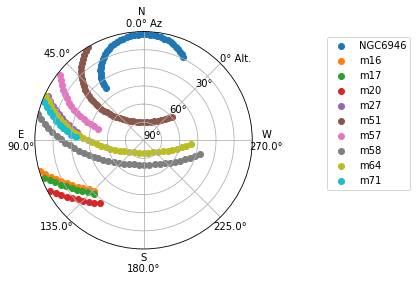

In [50]:
for target in targets:
    ax = plot_sky(target, KittPeak, times);
    ax.legend(bbox_to_anchor=(1.75,1))

//anaconda/envs/py34/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


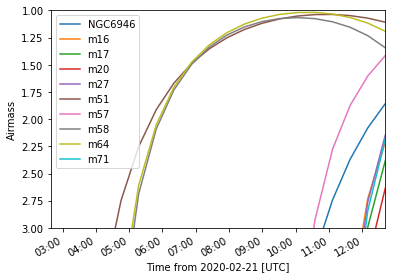

In [51]:
for target in targets:
    plot_airmass(target, KittPeak, t_observe)
    plt.legend()
    plt.grid()

In [52]:
table = observability_table(constraints, KittPeak, targets, time_range = t_range)
print(table)

target name ever observable always observable fraction of time observable
----------- --------------- ----------------- ---------------------------
    NGC6946            True             False         0.21739130434782608
        m16            True             False         0.13043478260869565
        m17            True             False         0.08695652173913043
        m20            True             False         0.08695652173913043
        m27            True             False         0.13043478260869565
        m51            True             False           0.782608695652174
        m57            True             False          0.2608695652173913
        m58            True             False          0.7391304347826086
        m64            True             False          0.7391304347826086
        m71            True             False         0.13043478260869565


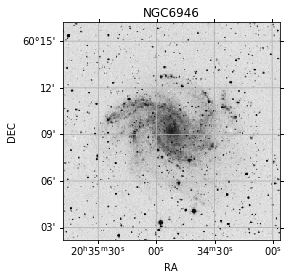

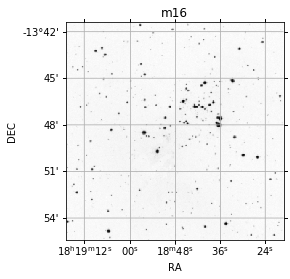

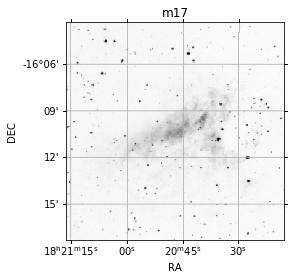

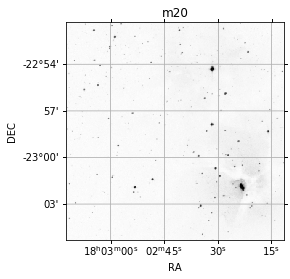

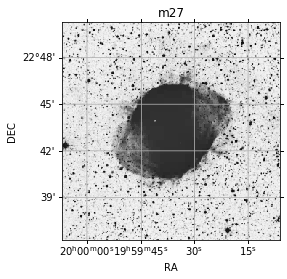

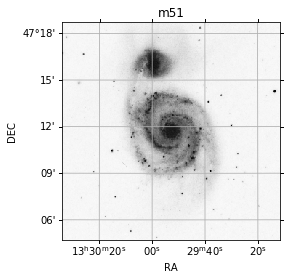

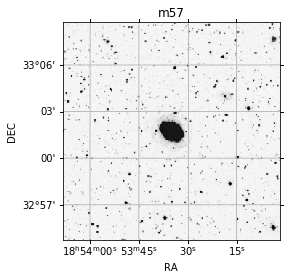

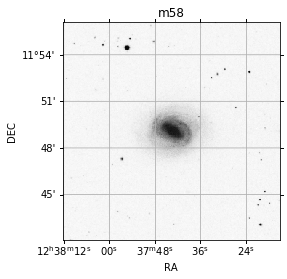

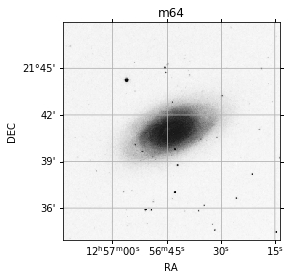

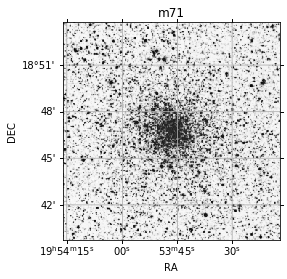

In [53]:
# field of view corresponding to the MLO 1.0-m telesocpe
fov = 14*u.arcmin

for target in targets:
    # plot the image
    plot_finder_image(target, fov_radius=fov); 
    plt.show();